[![ Click here to deploy.](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/launchable/deploy?launchableID=env-2p81OcxdHAJZLSOc2KW14WW1YU8)

<div class="alert alert-block alert-info"> <b>NOTE</b> It takes about 10 minutes to deploy this notebook as a Launchable. As of this writing, we are working on a free tier so a credit card may be required. You can reach out to your NVIDIA rep for credits. (Note: This links to the nightly release and may be out of sync with these docs.) </div>

# Zero-Shot Protein Design Using ESM-2

*We thank Adrian Lange from A-Alpha Bio for originally contributing this recipe. This notebook has since been modified by NVIDIA.*

## Demo Objectives

1. **ESM-2nv Inference Functionality**
    * Objective: Perform inference on the pre-trained ESM-2 model.
    * Steps: Download model checkpoints, create CSV data file of protein sequences, and generate hidden state representations and sequence embeddings from input protein sequences.
2. **Logit and Probability Extraction**
    * Objective: Obtain probability values of all possible tokens at each position in the amino acid sequence.
    * Steps: Generate logits from hidden states, and transform them into probabilities.
3. **Protein Mutant Design**
    * Objective: Optimize an input protein sequence to align it more closely with naturally occurring protein variants.
    * Steps: Sequentially mask amino acids, extract per-position probabilities (and create a heatmap), analyze positions where single-point mutants have higher likelihood than wild-type, and develop new candidates.

## Background

ESM-2 is a large-scale protein language model (PLM) trained on millions of protein sequences. It can capture complex patterns and relationships in protein sequences, allowing it to be used to predict likely amino acid substitutions at different positions. By leveraging ESM-2's masked language modeling (MLM) capabilities, we can identify potential mutations that may enhance a protein's properties or align it more closely with naturally occurring variants. ESM-2 has 650M and 3B parameter versions - for this demo, we will be using ESM-2 3B.

## Setup

This notebbok should be executed inside the BioNeMo docker container, which has all ESM-2 dependencies pre-installed. This tutorial assumes that a copy of the BioNeMo framework repo exists on workstation or server and has been mounted inside the container at `/workspace/bionemo2`. For more information on how to build or pull the BioNeMo2 container, refer to the [Initialization Guide](https://docs.nvidia.com/bionemo-framework/latest/user-guide/getting-started/initialization-guide/).

<div class="alert alert-block alert-info"> <b>NOTE</b> Some of the cells below generate long text output. We're using <pre>%%capture --no-display --no-stderr cell_output</pre> to suppress this output. Comment or delete this line in the cells below to restore full output.</div>

### Import Required Libraries

In [1]:
%%capture --no-display --no-stderr cell_output

import os
import torch
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


### Work Directory

Set the work directory to store data and results:

<div class="alert alert-block alert-info"> <b>NOTE</b> We set the following to clean up the work directory created by this notebook  <pre>cleanup : bool = True</pre></div>

In [2]:
cleanup : bool = True

In [3]:
work_dir="/workspace/bionemo2/esm2_mutant_design_tutorial"

if cleanup and os.path.exists(work_dir):
    shutil.rmtree(work_dir)

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
    print(f"Directory '{work_dir}' created.")
else:
    print(f"Directory '{work_dir}' already exists.")

Directory '/workspace/bionemo2/esm2_mutant_design_tutorial' created.


### Download Model Checkpoints
The following code will download the pre-trained model, `esm2/3b:2.0`, from the NGC registry:

In [4]:
from bionemo.core.data.load import load

checkpoint_path = load("esm2/3b:2.0", source="ngc")
print(checkpoint_path)

/home/bionemo/.cache/bionemo/a2248cfed1ef39f83bd32a0e08b84c0a8f39325d383e2d92767022ff7f5260ed-esm2_3B_nemo2.tar.gz.untar


## ESM-2 Inference

In this section, we will explore the key inference functionalities of the pre-trained model. 

### Data

In the first step we prepare the data by creating a CSV file with `sequences` column that holds the protein sequences that we use as inference input.

In [5]:
import pandas as pd

sequences = [
    'MSLKRKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL', # length: 41
    'MIQSQINRNIRLDLADAILLSKAKKDLSFAEIADGTGLA', # length: 39
]
# Create a DataFrame
df = pd.DataFrame(sequences, columns=["sequences"])

# Save the DataFrame to a CSV file
data_path = os.path.join(work_dir, "sequences.csv")
df.to_csv(data_path, index=False)

### Tokenizer

Let's also check the tokenizer vocabulary.

In [6]:
from bionemo.esm2.data.tokenizer import get_tokenizer, BioNeMoESMTokenizer
tokenizer = get_tokenizer()

tokens = tokenizer.all_tokens
print(f"There are {tokenizer.vocab_size} unique tokens: {tokens}.")

There are 33 unique tokens: ['<cls>', '<pad>', '<eos>', '<unk>', 'L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C', 'X', 'B', 'U', 'Z', 'O', '.', '-', '<null_1>', '<mask>'].


Let's set aside the tokens corresponding to the 20 known amino acids.

In [7]:
aa_tokens = ['L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C']

aa_indices = [i for i, token in enumerate(tokens) if token in aa_tokens]
extra_indices = [i for i, token in enumerate(tokens) if token not in aa_tokens]

### Obtaining Model Outputs

ESM-2nv was trained with a Masked Language Modeling (MLM) objective. Thus, we are able to mask a position in an amino acid sequence and obtain values for the most probable amino acids at that position, based on the surrounding context. Let's sequentially obtain these values for every position in the sequence.


The hidden states (which are usually the output of each layer in a neural network) can be obtained by using `--include-hiddens` argument when calling the inference function of ESM-2 in BioNeMo Framework.

The hidden states can be converted into fixed-size vector embeddings. This is done by removing the hidden state vectors corresponding to padding tokens, then averaging across the rest. This process is often used when the goal is to create a single vector representation from the hidden states of a model, which can be used for various sequence-level downstream tasks such as classification (e.g. subcellular localization) or regression (e.g. melting temperature prediction). To obtain the embedding results we can use `--include-embeddings` argument.

By passing the hidden state of an amino acid sequence through the BERT language model head, we can obtain output logits at each position and transform them into probabilities. This can happen by using `--include-logits` argument. Logits here are the raw, unnormalized scores that represent the likelihood of each class and are not probabilities themselves; they can be any real number, including negative values.

When we apply the softmax function to logits, it converts them into a probability distribution over the classes, where the sum of probabilities equals 1.

Now lets call `infer_esm2` executable with relevant arguments to compute and optionally return embeddings, hiddens and logits.

In [8]:
%%capture --no-display --no-stderr cell_output

results_path = os.path.join(work_dir, "inference_results.pt")

! infer_esm2 --checkpoint-path {checkpoint_path} \
             --data-path {data_path} \
             --results-path {results_path} \
             --include-hiddens \
             --include-embeddings \
             --include-logits \
             --include-input-ids


This will write the output of ESM-2 inference into a python dictionary and save that into `inference_results.pt` which can be loaded via PyTorch:

In [9]:
results = torch.load(results_path)

for key, val in results.items():
    if val is not None:
        print(f'{key}\t{val.shape}')

token_logits	torch.Size([1024, 2, 128])
hidden_states	torch.Size([2, 1024, 2560])
input_ids	torch.Size([2, 1024])
embeddings	torch.Size([2, 2560])


Logits (`token_logits`) tensor has a dimension of `[sequence, batch, hidden]` to improve the training performance. We will transpose the first two dimension in the following to have batch-first shape like the rest of the output tensors. 

In [10]:
logits = results['token_logits'].transpose(0, 1).to(torch.float32)  # s, b, h  -> b, s, h
print(logits.shape)

torch.Size([2, 1024, 128])


The sequnce dimension of `toke_logits` is 1024, which includes begining-of-sequence, end-of-sequence (eos/bos) and padding. The last dimension of `token_logits` is 128, with the first 33 positions corresponding to the amino acid vocabulary, followed by 95 paddings. We use the `tokenizer.vocab_size` to filter out the paddings and only keep the 33 vocab positions.

In [11]:
aa_logits = logits[..., :tokenizer.vocab_size]  # filter out the 95 paddings and only keep 33 vocab positions
print(aa_logits.shape)

torch.Size([2, 1024, 33])


We will force the probabilities of non-amino acid tokens to become zero by calling softmax on `-inf`. These tokens IDs are listed as `extra_indices` and we set the logits values to `-inf`.


Now we can convert the logits to probabilities using PyTorch Softmax function.   


In [12]:
aa_logits[..., extra_indices] = - torch.inf  # force non-amino acid token probs to zero

probs = torch.softmax(aa_logits, dim=-1)

# check that rows sum to 1
# probs.sum(dim=-1)

These steps are summerized in the `logits_to_probs()` function below:

In [13]:
def logits_to_probs(
        logits: torch.Tensor, tokenizer: BioNeMoESMTokenizer = get_tokenizer()
) -> torch.Tensor:
    """Convert token logits to probabilities

    Args:
        logits (torch.Tensor): logits tensor with the [batch, sequence, hidden] dimensions
        tokenizer (BioNeMoESMTokenizer): ESM2 tokenizer

    Returns:
        probabilities (torch.Tensor): probability tensor with [batch, sequence, tokenizer.vocab_size]
    """
    aa_tokens = ['L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C']
    extra_indices = [i for i, token in enumerate(tokenizer.all_tokens) if token not in aa_tokens]

    aa_logits = logits[..., :tokenizer.vocab_size]  # filter out the 95 paddings and only keep 33 vocab positions
    aa_logits[..., extra_indices] = - torch.inf  # force non-amino acid token probs to zero
    return torch.softmax(aa_logits, dim=-1)


#### Note
The sequence dimension in this example (1024) is representing the max sequence length wich includes paddings, EOS, and BOS. To filter the relevant amino acid information we can use the input sequence IDs in the results to create a mask:

```python
    input_ids = results['input_ids'] # b, s
    # mask where non-amino acid tokens are True
    mask = torch.isin(input_ids, torch.tensor(extra_indices))
```

## Mutant Design through ESM-2nv

In this section, we aim to optimize an input protein sequence by introducing single-point mutations that align it more closely with naturally occurring protein variants. These mutants may present properties that enhance the protein's functionality, such as improved stability or increased catalytic activity. By leveraging ESM-2's masked language modeling capabilities, we can identify amino acid substitutions with higher likelihood than the wild-type residues. This approach allows us to explore the protein sequence space efficiently, potentially discovering variants with superior characteristics.

### Sequential Masking

Let's take a starting sequence and scan through the positions, iteratively placing a `<mask>` token in place of the existing amino acid at each position. We will then predict probabilities at each masked location. If you only want to analyze substitutions within a predefined portion of the sequence (e.g. a specific alpha helix), you can set `start_pos` and `end_pos` accordingly, below.

In [14]:
seq = 'MSLKRKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL' # length: 41

start_pos = 0
end_pos = len(seq)

In [15]:
positions = np.arange(start_pos, end_pos)

sequentially_masked = list()
for index in positions:
    masked = seq[:index] + "<mask>" + seq[index+1:]
    sequentially_masked.append(masked)

Let's save the masked sequences into a CSV file and look at the first few elements of `sequentially_masked_sequences`:

In [16]:
# Create a DataFrame
df = pd.DataFrame(sequentially_masked, columns=["sequences"])

# Save the DataFrame to a CSV file
masked_data_path = os.path.join(work_dir, "sequentially_masked_sequences.csv")
df.to_csv(masked_data_path, index=False)


df.head(n=5)

,sequences
0,<mask>SLKRKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL
1,M<mask>LKRKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL
2,MS<mask>KRKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL
3,MSL<mask>RKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL
4,MSLK<mask>KNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL


### Extraction of Probabilities

We now extract the logits and convert them to probability matrix for each element of `sequentially_masked`. This can easily be done by calling the inference function above with `--include-logits` and using softmax to convert the logits to probabilities. We can then select the probability vectors corresponding to the masked positions, and combine them into a final probability matrix.

In [17]:
%%capture --no-display --no-stderr cell_output

sequentially_masked_results_path = os.path.join(work_dir, "sequentially_masked_inference_results.pt")

! infer_esm2 --checkpoint-path {checkpoint_path} \
             --data-path {masked_data_path} \
             --results-path {sequentially_masked_results_path} \
             --include-logits \
             --include-input-ids

In [18]:
results = torch.load(sequentially_masked_results_path)
logits = results['token_logits'].transpose(0, 1).to(torch.float32)  # s, b, h  -> b, s, h

probs = logits_to_probs(logits)
print(probs.shape)

torch.Size([41, 1024, 33])


We are only interested in the probabilities associate with the amino acid tokens. So we need to ignore padding, and eos/bos tokens. Since all the sequence have the same length we can use that to filter them:

In [19]:
probas_final = probs[:, 1:positions.size+1, :]
probas_final.shape

torch.Size([41, 41, 33])

Select and combine probabilities corresponding to each mask

In [20]:
probas_final = probas_final[np.arange(probas_final.shape[0]), positions, :]
print(probas_final.shape)

torch.Size([41, 33])


### Amino Acid Heatmap

Let's visualize the results. We can plot the predicted probabilities of each token across all positions of interest.

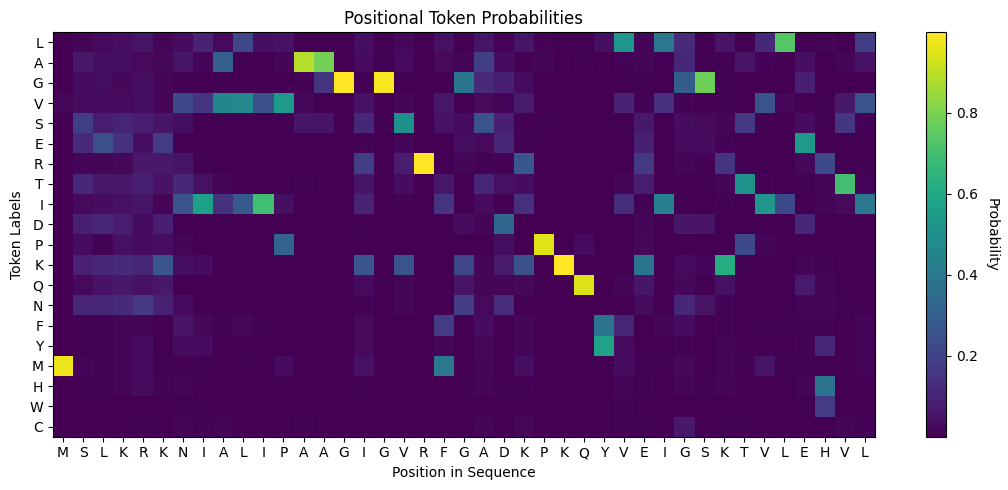

In [21]:
# Create heatmap
dat = probas_final[:, aa_indices]

plt.figure(figsize=(11, 5))
im = plt.imshow(dat.T, cmap='viridis', aspect='auto')

# Add color scale
cbar = plt.colorbar(im)
cbar.set_label('Probability', rotation=270, labelpad=15)

# Set y-axis labels (amino acid tokens) and x-axis labels (position in sequence)
plt.yticks(ticks=np.arange(len(aa_tokens)), labels=aa_tokens)
plt.xticks(ticks=np.arange(dat.shape[0]), labels=list(seq))
plt.gca().xaxis.set_ticks_position('bottom')

# Add axes titles and main title
plt.xlabel('Position in Sequence')
plt.ylabel('Token Labels')
plt.title('Positional Token Probabilities')

# Adjust layout to prevent clipping of labels
plt.tight_layout()

plt.show()

### Mutant Discovery

We can now translate the logits/probabilities back into the sequence space, by mapping the highest probability in each position to the corresponding amino acid. 

In [22]:
# Predicted seq (Argmax --> Collect token IDs of predicted seq --> Convert to amino acids)
pred_idx_list = np.argmax(probas_final, axis=-1).tolist()
pred_seq = "".join([tokenizer.id_to_token(id) for id in pred_idx_list])

# Original seq
true_idx_list = [tokenizer.token_to_id(seq[i]) for i in positions]
true_seq = "".join([tokenizer.id_to_token(id) for id in true_idx_list])

Let's compare the sequences and visually inspect the positions where a mutant is suggested over the wild-type. Note that the predicted sequence is displayed on the top, and the original sequence is on the bottom.

In [23]:
# Compare prediction (reconstruction) to true (input sequence)
display(pred_seq + " (Predicted Sequence)")
display(
    "".join(
        ["." if a == b else "|" for a, b in zip(pred_seq, true_seq)]
    )
)
display(true_seq + " (Input Sequence)")

'MSEENKIIVVIVAAGKGSRMGSDRPKQYLKIGGKTILEHTI (Predicted Sequence)'

'..|||.|.||.|...|.|.|.|.|....||..|..|...||'

'MSLKRKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL (Input Sequence)'

Amongst the mismatches, we can:
1. Collect all positions where a mutant is suggested over the wild-type amino acid.
2. At these positions, find the mutant with the highest probability.

In [24]:
# Collect indices where a mutant is suggested over the wild-type
matches = [c1 == c2 for c1, c2 in zip(pred_seq, true_seq)]
mismatch_index = [i for i, value in enumerate(matches) if not value]

# Filter probability matrix to mismatches-only
probas_mismatch = probas_final[mismatch_index, :]

# Find index of mutant with highest likelihood
index_flat = np.argmax(probas_mismatch)
index_2d = np.unravel_index(index_flat, probas_mismatch.shape)
index_of_interest = mismatch_index[index_2d[0]]
position_of_interest = positions[index_of_interest]
print("Position:", position_of_interest)
print("Mutation:", true_seq[position_of_interest] + str(position_of_interest) + pred_seq[position_of_interest])

Position: 32
Mutation: S32G


Let's check the probability associated to mutations at this position.

In [25]:
# Sort tokens by probability
token_ids_sort = sorted(enumerate(probas_final[index_of_interest]), key=lambda x: x[1], reverse=True)

tokens_sort = [(tokenizer.all_tokens[i], i, p.item()) for i, p in token_ids_sort]

tokens_sort_df = pd.DataFrame(tokens_sort, columns=['Token', 'Token ID', 'Probability'])
tokens_sort_df.head()

,Token,Token ID,Probability
0,G,6,0.779755
1,D,13,0.053063
2,N,17,0.052240
3,E,9,0.032691
4,S,8,0.023547


It's clear that for this position, the amino acid Glycine (G) has a higher likelihood than the wild-type, Serine (S). In this way, we can use ESM-2nv to design novel mutant candidates for downstream testing.

There are many ways that we can engineer candidates from ESM-2nv outputs. We can continue finding the top _n_ single-point mutants, find the top _n_ double- or multi-point mutants, randomly sample over the probability space generated by the input sequence, sample only within certain positions of interest (e.g. known active sites), etc. Through this process, a set of mutants can be developed for further _in silico_ or wet lab testing.